## Intro

- Notebook for creating and training a lens model to use with the toy sequence dataset  
 - To create the dataset, run toy_data_dataset.ipynb
 - To create the vae, run toy_data_vae.ipynb
- Settings in the Parameters section (below) are used in creating and training the network  
 - Comment one of the versions (Full/Quick) of settings out below, or set them how you like

## Parameters

In [1]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta

save_loc = "saved/toy_seqs"
ae_loc = save_loc
data_loc = save_loc

BATCH_SIZE = 32

root_logdir = save_loc + "/logs"





## Full 
reps = 5  # Number of times to repeat for each parameter setting  
epochs = 100 #  Max number of training epochs 
EARLY_STOP = 4 # Stop training if no improvements after this many steps    
flow_depth_options = [5, 10, 15] # List of flow depths to try 
inter_dims_options = [[1024, 128, 32], ] # List of lists. Each inner is number of units to use in intermideate layers of lens models
optimizer_options = [Adam(), RMSprop()] # List of optimizers to try
beta_options = [0.2, 0.5, 0.8, 1.0] # List of beta constants to try
gamma_options = [2.0, 1.0]  # List of gamma constants to try


## Quick 
reps = 1 
epochs = 10
EARLY_STOP = 2
flow_depth_options = [10]
inter_dims_options = [[1024, 128, 32], ]
optimizer_options = [Adam()]
beta_options = [0.5]
gamma_options = [2.0]

## Imports

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy


from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
import time

from my_lib.save_load import load_datasets, load_seq_vae, save_ilvm
from my_lib.models.vae_sequence import START, SCALE
from my_lib.models.common_functions import sampling2, Linear, log_normal_pdf
from my_lib.models.planar_flows import PlanarFlow
from my_lib.models.filvm import FILVM 
from my_lib.helpers import walk_ld, make_plots, make_id, param_search_to_list

## Load training data

In [3]:
all_data = load_datasets(data_loc)


print("\nColumns of s are: start, stop, step, length\n")
for name, model in all_data.items():
    name = name.split(".")[0]
    exec("{} = model".format(name))
    print("initialized variable,", name)
    
max_len = max(s_tr[:,-1])
print("\nMax seq lenght is", max_len)

all_seqs = []
lens_tr = s_tr[:,-1].copy()
lens_cv = s_cv[:,-1].copy()

for s in (s_tr, s_cv):
    # create seqs
    eff_stops = s[:,0] + s[:, 2]*max_len
    expanded_seqs = [np.arange(x[0],eff_s, x[2] ) for x, eff_s in zip(s, eff_stops)]
    all_seqs.append(expanded_seqs)
    
    # scale each attribute 
    for i in range(s.shape[1]):
        low, high = float(min(s[:,i])), float(max(s[:,i]))
        s[:,i] = (s[:,i]-low) / (high-low)
        
all_seqs_tr, all_seqs_cv = all_seqs

failed to load .ipynb_checkpoints (This is probably fine, unless it's needed)

Columns of s are: start, stop, step, length

initialized variable, s_cv
initialized variable, s_tr

Max seq lenght is 29.0


In [4]:

seqs_tr = tf.expand_dims(
            tf.keras.preprocessing.sequence.pad_sequences(all_seqs_tr, 
                                                          padding='post', dtype="float32"), -1)
mask = tf.expand_dims(tf.sequence_mask(lens_tr, dtype=tf.float32, maxlen=seqs_tr.shape[1]),-1)
seqs_tr *= mask


seqs_cv = tf.expand_dims(
            tf.keras.preprocessing.sequence.pad_sequences(all_seqs_cv, 
                                                          padding='post', dtype="float32"), -1)
mask = tf.expand_dims(tf.sequence_mask(lens_cv, dtype=tf.float32, maxlen=seqs_cv.shape[1]),-1)
seqs_cv *= mask


dataset_cv = tf.data.Dataset.from_tensor_slices((seqs_cv/SCALE, lens_cv)).shuffle(len(seqs_cv))
dataset_cv = dataset_cv.batch(32, drop_remainder=True)

## Load VAE

In [5]:
vae = load_seq_vae(ae_loc)

encoder = vae.encoder 
decoder =  vae.decoder 
len_decoder = vae.len_decoder

## Set up filvm training data

In [6]:
#pick 2 to use, order is: start, step, seq_len
sdims =(0,2)  #pair of dims

In [7]:
z_train, _, _ = vae.encoder(seqs_tr/SCALE)
latent_dim = z_train.shape[1]

In [8]:
z_train1, z_train2, s0_1, s0_2, s1_1, s1_2, = train_test_split(z_train.numpy(),
                                                                s_tr[:,sdims[0]], 
                                                                s_tr[:,sdims[1]], 
                                                                test_size= 0.5,
                                                             )

z_train1 = tf.constant(z_train1, dtype=tf.float32)
z_train2 = tf.constant(z_train2, dtype=tf.float32)
s0_1 = tf.constant(s0_1, dtype=tf.float32)
s0_2 = tf.constant(s0_2, dtype=tf.float32)
s1_1 = tf.constant(s1_1, dtype=tf.float32)
s1_2 = tf.constant(s1_2, dtype=tf.float32)

#### And test data

In [9]:
z_cv, _, _ = vae.encoder(seqs_cv/SCALE)

s0_cv = tf.constant(s_cv[:, sdims[0]], dtype=tf.float32)
s1_cv = tf.constant(s_cv[:, sdims[1]], dtype=tf.float32)

# used for plotting other ones
s_len_cv = tf.constant(s_cv[:, 3], dtype=tf.float32)
s_stop_cv = tf.constant(s_cv[:, 1], dtype=tf.float32)

In [10]:
# Constants
input_z_shape = (latent_dim, )
batch_size = 32

flow_dim = latent_dim
z_dim = latent_dim

shuf_size = (z_train1.shape[0]//batch_size) *batch_size

#### Make datasets

In [11]:
ds1 = tf.data.Dataset.from_tensor_slices((z_train1, s0_1, s1_1)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds1

<BatchDataset shapes: ((32, 4), (32,), (32,)), types: (tf.float32, tf.float32, tf.float32)>

In [12]:
ds2 = tf.data.Dataset.from_tensor_slices((z_train2, s0_2, s1_2)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds2

<BatchDataset shapes: ((32, 4), (32,), (32,)), types: (tf.float32, tf.float32, tf.float32)>

In [13]:
ds_test = tf.data.Dataset.from_tensor_slices((z_cv, s0_cv, s1_cv)).shuffle(
    shuf_size, reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
ds_test

<BatchDataset shapes: ((32, 4), (32,), (32,)), types: (tf.float32, tf.float32, tf.float32)>

# Build filvm model 

### loss_fn

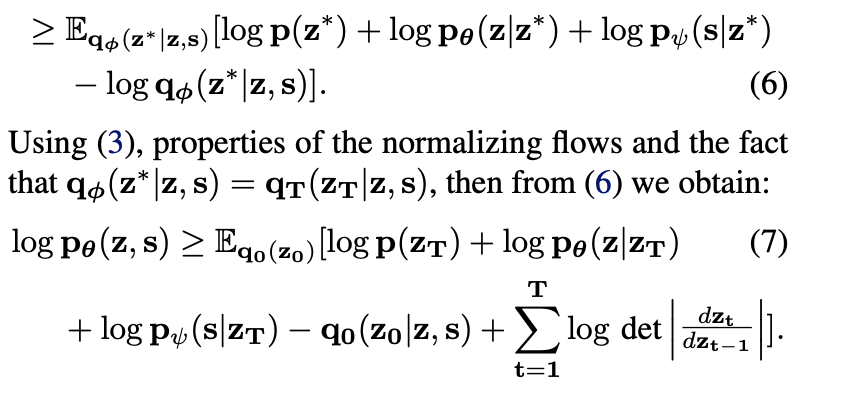

In [14]:
from tensorflow.keras.losses import MSE, categorical_crossentropy
def multinomial_loss_function(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t, beta=1.0, gamma=1.0): 
    """
    :param z_pred: shape: (batch_size, latent_dim), real valued, mean of p_theta(z|z*)
    :param z:       shape (batch_size, latent_dim), original z
    
    :param s_logit: shape: (batch_size, s_digit_dim + s_rot_dim), real valued logits, first 10 cols contain digit, rest are rot
    :param s:       shape: (batch_size, s_digit_dim + s_rot_dim), concated one-h encoding of digit and rot info
    
    :param z_0: first stochastic latent variable
    :param log_q_z0: log denisty of z_0
    
    :param z_t: last stochastic latent variable
    :param ldj: log det jacobian
    
    Note: elbo = log_p_zt + log_p_theta + log_p_psi - log_q_z0 + log_dets    [loss = -elbo]
    """
    
    
    log_p_zt = log_normal_pdf(z_t, mean=0.,  logvar=0.)
    
    log_p_theta = log_normal_pdf(z, mean=z_pred, logvar=0.) #log_normal_pdf(z, mean=z_pred, logvar=0.)
    
#
    # bad names, now s0, s1
    digit_p = -MSE(s[0], s_pred[0])
    thick_p = -MSE(s[1], s_pred[1])     
    
    log_p_psi = digit_p + thick_p 
     
    
    recons_loss = -(log_p_theta*gamma + log_p_psi)
    kl_loss = log_q_z0 - log_dets - log_p_zt


    loss = recons_loss + kl_loss*beta
    return tf.reduce_mean(loss)
  

  

def lf_reconstr_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t): 

    
    log_p_theta = log_normal_pdf(z, mean=z_pred, logvar=0.)
    
    #digit_p = -categorical_crossentropy(s[0], s_pred[0], from_logits=True)
    digit_p = log_normal_pdf(s[0], mean=s_pred[0], logvar=0.)
    rot_p = log_normal_pdf(s[1], mean=s_pred[1], logvar=0.)
    log_p_psi = tf.add(digit_p, rot_p)
    

    loss = -tf.reduce_mean(log_p_theta + log_p_psi)
    return loss


def lf_kl_loss(z_pred, z, s_pred, s, z_0, log_q_z0, log_dets, z_t): 
    log_p_zt = log_normal_pdf(z_t, mean=0.,  logvar=0.)
    loss = log_q_z0 - log_dets - log_p_zt
    return tf.reduce_mean(loss)


    

metrics = []
metrics.append(('reconstr_loss', lf_reconstr_loss))
metrics.append(('kl_loss', lf_kl_loss))

In [15]:


def build_filvm(latent_dim = 2, 
               flow_depth = 5, 
               inter_dims = [1024, 256, 16], 
               optimizer = tf.keras.optimizers.Adam(), 
               metrics = [], 
               loss_fn = None, 
               beta=1.0, 
               gamma=1.0, 
              ):

    input_z = Input(shape=(z_dim, ), batch_size=batch_size,name='z_in')
    input_s_d = Input(shape=(1, ), batch_size=batch_size,name='s_0')
    input_s_t = Input(shape=(1,), batch_size=batch_size,name='s_1')

    recnet1_in = [input_z, input_s_d, input_s_t]
    recnet1_in_cc = tf.keras.layers.concatenate(recnet1_in, axis=1)


    #############  Recnet 1 ##############
    x = Dense(inter_dims[0], activation='relu')(recnet1_in_cc)
    for dim in inter_dims[1:]:
        x = Dense(dim, activation='relu')(x)
    

    w = Dense(flow_dim * flow_depth, name='w')(x)
    u = Dense(flow_dim * flow_depth, name='u')(x)
    b = Dense(1 * flow_depth, name='b')(x)


    z0_mean = Dense(z_dim, name='z0_mean')(x)
    z0_log_var = Dense(z_dim, name='z0_log_var')(x)
    z0, log_q0 = Lambda(sampling2, output_shape=(z_dim,), name='z_0')([z0_mean, z0_log_var])

    recnet1 = Model(recnet1_in, [z0_mean, z0_log_var, z0, log_q0, w, u, b], name='recnet1')


    #############  Srn ##############
    x = Dense(inter_dims[0], activation='relu')(input_z)
    for dim in inter_dims[1:]:
        x = Dense(dim, activation='relu')(x)

    s_d_out = Dense(1, name='s_dig_out')(x)
    s_t_out = Dense(1, name='s_thc_out')(x)

    srn = Model(input_z, (s_d_out, s_t_out), name='srn')


    #####                      Flow             #####   
    pf_layers = [PlanarFlow() for _ in range(flow_depth)]

    

    #####                  Generative model             #####    
    gen_inputs1 = Input(shape=(z_dim,), batch_size=32, name='zt_full')
    gen_inputs2 = Input(shape=(z_dim,), batch_size=32, name='zt_0')
    gen_inputs3 = Input(shape=(z_dim,), batch_size=32, name='zt_1')


    # theta part
    x = Dense(inter_dims[-1], activation='relu', name="gm_theta_1")(gen_inputs1)
    for dim in reversed(inter_dims[:-1]):
        x = Dense(dim, activation='relu')(x)

    output_z = Dense(z_dim, name="gm_theta_4")(x)  

    # psi part
    output_s_d = Linear(input_dim=1, output_dim=1, name="s_0_pred")(tf.expand_dims(gen_inputs2[:,0],axis=1))
    output_s_t = Linear(input_dim=1, output_dim=1, name="s_0_pred")(tf.expand_dims(gen_inputs3[:,1],axis=1))



    # instantiate generative model
#     gm = Model(gen_inputs, output, name='generative_model')
    gm1 = Model(gen_inputs1, output_z, name='generative_model1')
    gm2 = Model(gen_inputs2, output_s_d, name='generative_model2')
    gm3 = Model(gen_inputs3, output_s_t, name='generative_model3')

    
    gm = (gm1, gm2, gm3)
    
    ## filvm ##
    filvm = FILVM(recnet1, srn, pf_layers, gm,  optimizer, beta=beta, gamma=gamma, )
    filvm.set_metrics(metrics)
    filvm.set_loss_fn(multinomial_loss_function)
    
    return filvm
    


In [16]:
filvm = build_filvm(loss_fn=multinomial_loss_function, metrics=metrics)
z_dim

4

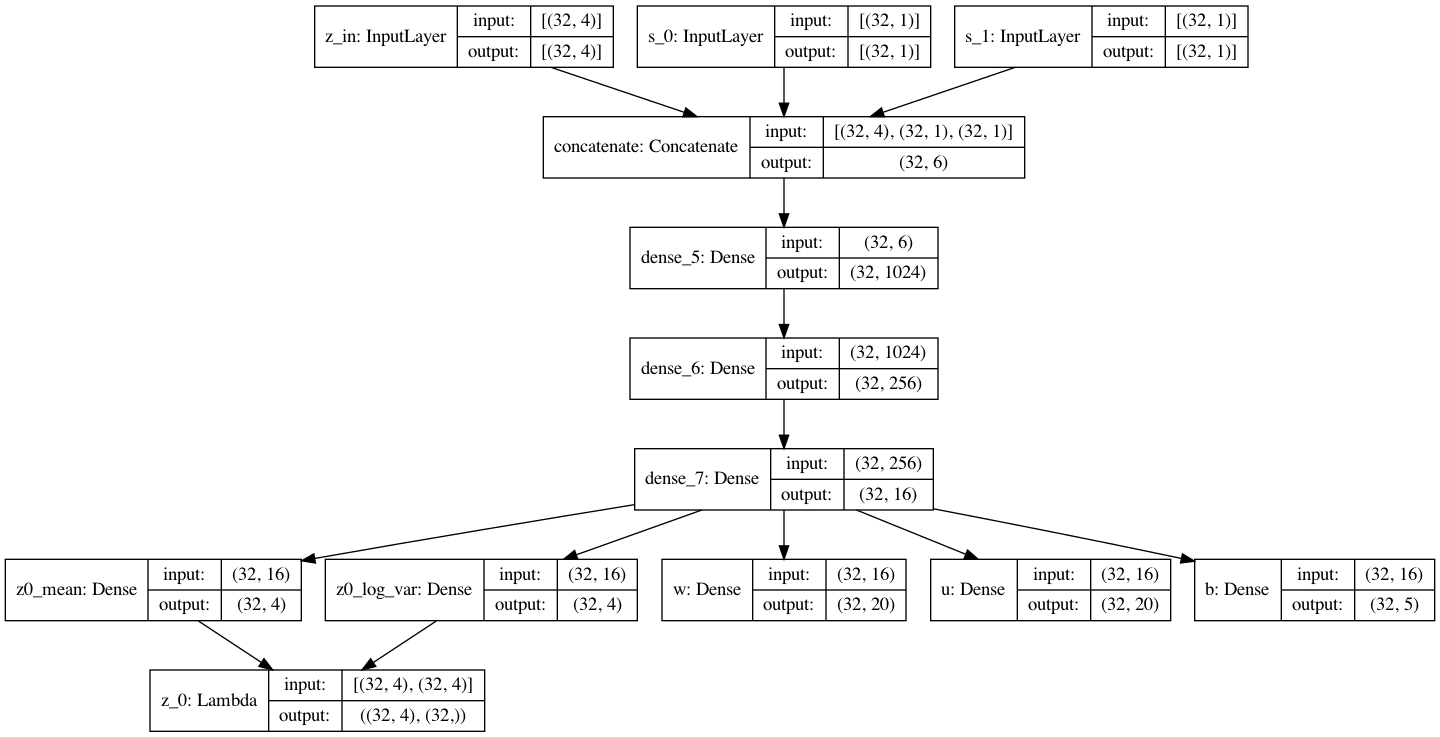

In [17]:
plot_model(filvm.recnet, show_shapes=True)

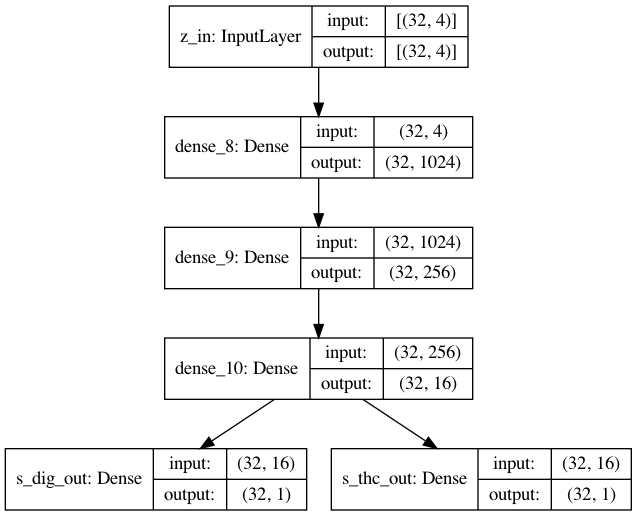

In [18]:
plot_model(filvm.srn, show_shapes=True)

In [19]:
# Planar flows

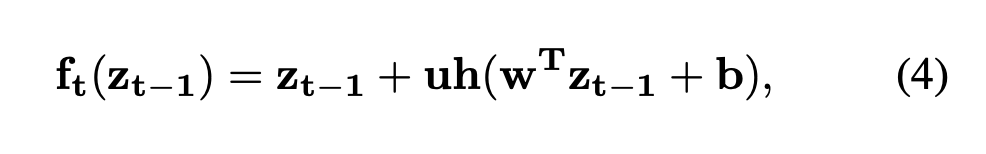 

h is tanh; w,u are vectors; b is scalar

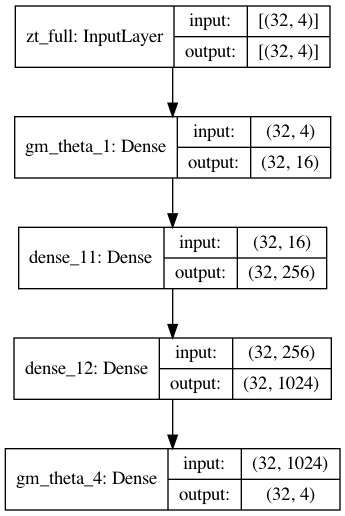

In [20]:
plot_model(filvm.gm1, show_shapes=True)

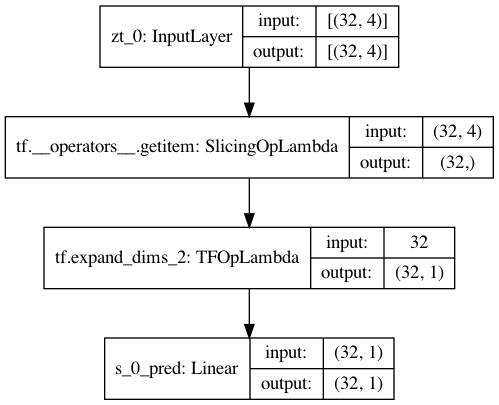

In [21]:
plot_model(filvm.gm2, show_shapes=True)

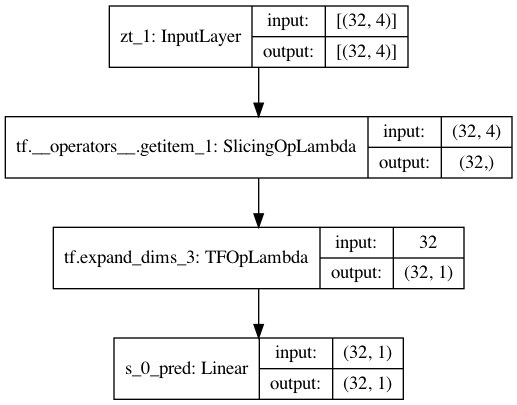

In [22]:
plot_model(filvm.gm3, show_shapes=True)

In [23]:
param_search = dict(flow_depth = flow_depth_options, 
                     inter_dims = inter_dims_options, 
                     optimizer = optimizer_options, 
                     beta= beta_options, 
                     gamma= gamma_options)




param_list = param_search_to_list(param_search)
len(param_list), param_list[0]

(1,
 {'gamma': 2.0,
  'beta': 0.5,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x1090a40d0>,
  'inter_dims': [1024, 128, 32],
  'flow_depth': 10})

In [24]:
trained = []

running: dep-10--inr-1024_128_32--opt-Adam--b-0_5--g-2_0--cv_full_loss--0
Epoch 1 Batch 0 Loss 1 21.5718
tr1_reconstr_loss 80.75542
tr1_kl_loss 0.14049241


Epoch 1 Batch 0 Loss 2 17.3384
tr2_reconstr_loss 79.958145
tr2_kl_loss 0.1180346
tr2_loss_srn_d 0.5103066
tr2_loss_srn_t 0.2849823
tr2_loss_srn 0.7952889


Epoch 1 Loss 549.8458
********** CV **********
Epoch 1 Loss 327.0731
cv_reconstr_loss 65.13282
cv_kl_loss 1.1409761
Epoch 2 Batch 0 Loss 1 8.3592
tr1_reconstr_loss 65.38509
tr1_kl_loss 1.0468855


Epoch 2 Batch 0 Loss 2 8.3993
tr2_reconstr_loss 64.9942
tr2_kl_loss 1.1421323
tr2_loss_srn_d 0.06566171
tr2_loss_srn_t 0.08949091
tr2_loss_srn 0.15515262


Epoch 2 Loss 541.7607
********** CV **********
Epoch 2 Loss 326.6655
cv_reconstr_loss 65.405785
cv_kl_loss 0.82438195
Epoch 3 Batch 0 Loss 1 8.3072
tr1_reconstr_loss 65.53741
tr1_kl_loss 1.1470435


Epoch 3 Batch 0 Loss 2 8.3751
tr2_reconstr_loss 65.04807
tr2_kl_loss 1.4529932
tr2_loss_srn_d 0.08202103
tr2_loss_srn_t 0.0739366
tr2_l

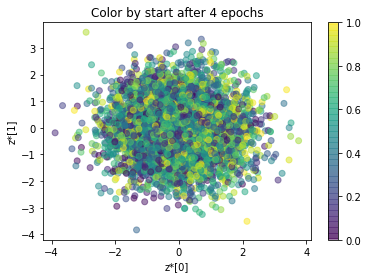

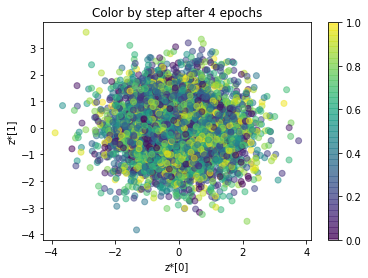

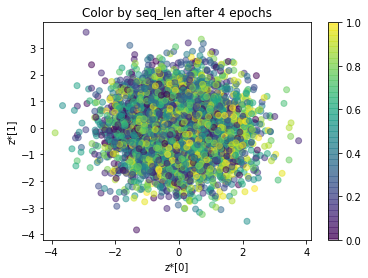

<Figure size 432x288 with 0 Axes>

In [25]:


watch =["cv_full_loss"]

for rep in range(reps):
    for params in param_list:
        for w in watch:

            id_str = make_id(params) + "--{}--{}".format(w, rep)
            print("running:", id_str)

            log_dir = "{}/{}".format(root_logdir, id_str)
            os.makedirs(log_dir, exist_ok=True)

            filvm = build_filvm(**params,loss_fn=multinomial_loss_function, metrics=metrics)

            trained.append((id_str, filvm))
            
            
            filvm.fit(epochs, log_dir, ds1=ds1, ds2=ds2, ds_test=ds_test, batch_size=BATCH_SIZE,
                      show=False, plot_freq=5, early_stop=EARLY_STOP, watch=w)
            

            n_ep = len(filvm.track[watch[0]])
        
        
            make_plots((z_cv, s0_cv, s1_cv), filvm, log_dir, n_ep,
               prefixs=["start", "step", "seq_len"], cs=[s0_cv, s1_cv, s_len_cv], save=False)
   

### View fit models

dep-10--inr-1024_128_32--opt-Adam--b-0_5--g-2_0--cv_full_loss--0


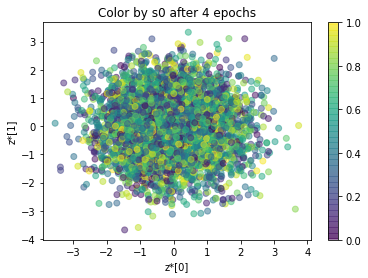

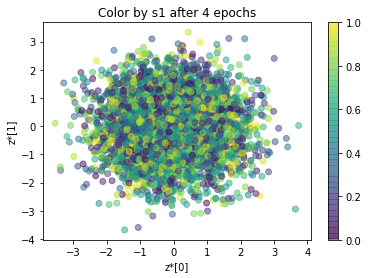

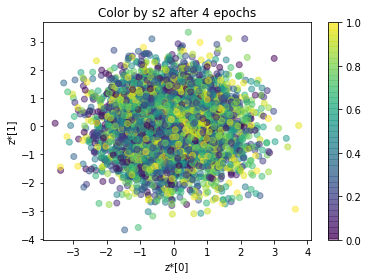

<Figure size 432x288 with 0 Axes>

In [26]:
max_show = 4
for i, (id_str, model) in enumerate(trained):
    print(id_str)
    
    n_ep = len(model.track[watch[0]])

    make_plots((z_cv, s0_cv, s1_cv), model, "", n_ep,
           prefixs=["s0", "s1", "s2"], cs=[s0_cv, s1_cv, s_len_cv], save=False)

    if i > max_show - 2:
        break

### Save trained filvm

In [27]:
find = "dep-10--inr-1024_128_32--opt-RMSprop--b-0_2--k-1_0--g-2_0--cv_full_loss--0"

for i, (id_str, filvm) in enumerate(trained):

    if id_str == find:
        print("found model, it is now filvm")
        break


In [28]:
save_ilvm(filvm, save_loc + "/lens_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved/toy_seqs/lens_model/models/recnet1/assets
INFO:tensorflow:Assets written to: saved/toy_seqs/lens_model/models/srn/assets
INFO:tensorflow:Assets written to: saved/toy_seqs/lens_model/models/generative_model1/assets
INFO:tensorflow:Assets written to: saved/toy_seqs/lens_model/models/generative_model2/assets
INFO:tensorflow:Assets written to: saved/toy_seqs/lens_model/models/generative_model3/assets


## Make figures

Sequences generated by changing z*[0] from -3 to 3
__________________________________________________
329 328 327 340 360 382 405 428 454 482 510 538
332 331 330 343 362 385 408 431 457 484 512 541
334 334 333 346 365 388 411 435 460 487 515 544
338 337 336 349 369 392 415 439 464 490 518 547 575
342 341 340 353 374 396 420 444 468 495 523 551 580
346 345 344 358 378 401 425 449 473 499 527 555 584
350 349 349 362 383 406 430 454 477 503 531 559 588
354 354 353 367 388 411 435 459 483 508 536 564 592
357 357 356 370 391 414 439 463 486 512 539 567 595 624
360 360 359 373 395 418 442 467 490 515 542 570 599 627
364 365 364 378 400 424 448 472 496 521 547 575 603 632
370 371 370 384 406 430 455 479 503 527 554 581 609 638
376 376 375 390 412 436 461 485 509 533 559 587 615 643 671
381 382 380 395 418 442 467 492 516 540 565 592 620 649 677
388 388 386 401 424 449 474 498 523 547 572 599 626 655 683
394 394 392 407 430 455 480 505 530 554 578 605 633 661 689
400 400 398 413 436 462 487 51

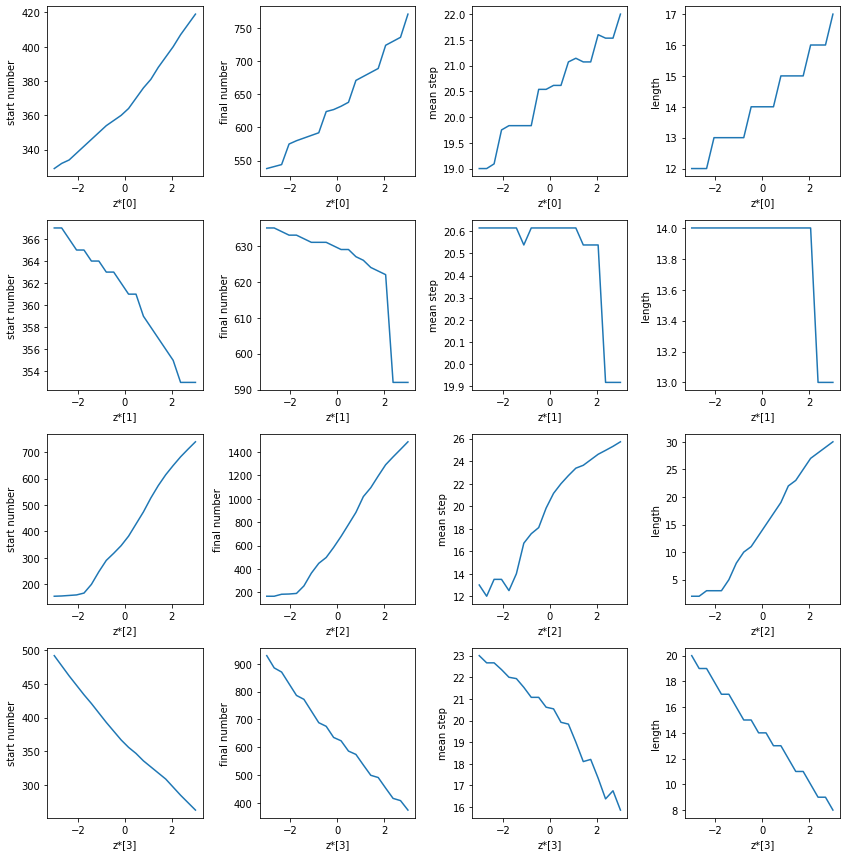

In [29]:
fig, axs = plt.subplots(z_dim, 4, figsize=(12,12))

for dim in range(z_dim):
    n = 20
    rng = (-3,3)
    # dim = 0

    z_star = np.zeros((n, z_dim))
    z_star[:,dim] = np.linspace(*rng, num=n)


    z_recons = filvm.gm1(z_star)
    context = z_recons

    dec_input = tf.expand_dims([START] * n, 1)
    dec_hidden = vae.initialize_hidden_state(n)

    pred_list = []
    pred_lens = tf.round(vae.len_decoder(context))

    max_len = int(max(pred_lens.numpy())[0])

    to_translate = np.zeros((n, max_len, 1)) #inp.shape


    for t in range(max_len):
        # passing enc_output to the decoder
        predictions, dec_hidden, = decoder((dec_input, context, dec_hidden))
        to_translate[:,t] = predictions
        dec_input = predictions

        
    print("Sequences generated by changing z*[{}] from {} to {}".format(dim, *rng))  
    print("_"*50)
    for i in range(n):

        pred = [x[0] for x in tf.round(to_translate[i]*SCALE).numpy()][:int(pred_lens[i])]
        pred_s = " ".join(map(str,map(int, pred)))
        print(pred_s)
    print("\n")
        

    to_plot = np.zeros((n, 4))
    for i in range(n):

        pred = [x[0] for x in tf.round(to_translate[i]*SCALE).numpy()][:int(pred_lens[i])]

        pl = len(pred)
        start, end = pred[0], pred[-1]
        ms = np.mean(np.diff(pred))

        to_plot[i,0] = start
        to_plot[i,1] = end
        to_plot[i,2] = ms
        to_plot[i,3] = pl



    for i, lbl in enumerate(["start number", "final number",  "mean step", "length"]):
        axs[dim, i].plot(z_star[:,dim], to_plot[:,i])
        axs[dim, i].set_xlabel("z*[{}]".format(dim))
        axs[dim, i].set_ylabel(lbl)
    
fig.tight_layout()
plt.show()
